In [9]:
#pip install rasterstats

In [5]:
#pip install matplotlib

In [1]:
#pip install scikit-learn


In [1]:
import pandas as pd
import rasterio
from rasterstats import zonal_stats
from osgeo import gdal
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyproj import CRS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pyproj

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
landcover = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/Isaias_Nj_Lat_Long_500.csv")
landcover.head()

,Unnamed: 0,ID,latitude,longitude,value
0,0,0,41.415450,-75.846241,128
1,1,1,41.410565,-75.846241,128
2,2,2,41.405680,-75.846241,128
3,3,3,41.400794,-75.846241,128
4,4,4,41.395909,-75.846241,128


In [4]:
wind = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Wind/Isaias_NJ_speed_backwinds_akshay_05302023.csv")
wind.head()

,ID,Center_Latitude,Center_Longitude,Distance,Vmax,Rmax
0,0,41.416894,-74.954401,303.584894,32.247100,120.546311
1,1,41.412650,-74.956148,303.889350,32.248157,120.546311
2,2,41.408405,-74.957895,304.193811,32.249218,120.546311
3,3,41.404161,-74.959642,304.498275,32.313243,120.546311
4,4,41.399917,-74.961389,304.802744,32.314315,120.546311


In [5]:
print(landcover.shape)
print(wind.shape)

(131364, 5)
(131610, 6)


- get zonal histogram for landcover data 

In [6]:
#check resolution of raster
with rasterio.open("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/NJ_All Layers_4326.tif") as src:
    # Print the bounding box coordinates
    print('Bounding box coordinates:', src.bounds)

    # Print the CRS
    print('CRS:', src.crs)

    #print resolution of raster
    print('Resolution:', src.res)

Bounding box coordinates: BoundingBox(left=-75.84624120900405, bottom=38.81163163562519, right=-73.54287375628081, top=41.41545006869191)
CRS: EPSG:4326
Resolution: (0.00027018973052471917, 0.00027018973052471917)


In [7]:
landcover.head()

,Unnamed: 0,ID,latitude,longitude,value
0,0,0,41.415450,-75.846241,128
1,1,1,41.410565,-75.846241,128
2,2,2,41.405680,-75.846241,128
3,3,3,41.400794,-75.846241,128
4,4,4,41.395909,-75.846241,128


In [12]:
landcover[["latitude","longitude"]].head()

,latitude,longitude
0,41.415450,-75.846241
1,41.410565,-75.846241
2,41.405680,-75.846241
3,41.400794,-75.846241
4,41.395909,-75.846241


In [6]:
landcover_zonal = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/zonal_500.csv")
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,2054340,-81750,2054840,-82250,0,0,0,0,0,0,0,0,0,0,0,289
1,2,2054340,-82250,2054840,-82750,0,0,0,0,0,0,0,0,0,0,0,272
2,3,2054340,-82750,2054840,-83250,0,0,0,0,0,0,0,0,0,0,0,289
3,4,2054340,-83250,2054840,-83750,0,0,0,0,0,0,0,0,0,0,0,289
4,5,2054340,-83750,2054840,-84250,0,0,0,0,0,0,0,0,0,0,0,272


In [7]:
histo_columns = ['HISTO_0', 'HISTO_1', 'HISTO_5', 'HISTO_6', 'HISTO_8', 'HISTO_10',
                 'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18', 'HISTO_NODATA']

# Convert HISTO columns to percentages
landcover_zonal[histo_columns] = landcover_zonal[histo_columns].div(landcover_zonal[histo_columns].sum(axis=1), axis=0) * 100
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,2054340,-81750,2054840,-82250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
1,2,2054340,-82250,2054840,-82750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,3,2054340,-82750,2054840,-83250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
3,4,2054340,-83250,2054840,-83750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,5,2054340,-83750,2054840,-84250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


#### Get Coordinates in degree from polygon grid

In [30]:
grid_latlong = gpd.read_file("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/Temp/Grid_Azi_500.shp")
grid_latlong.head()

,id,left,top,right,bottom,geometry
0,1.0,2054340.0,-81750.0,2054840.0,-81250.0,POINT (2054340.000 -81750.000)
1,2.0,2054340.0,-82250.0,2054840.0,-81750.0,POINT (2054340.000 -82250.000)
2,3.0,2054340.0,-82750.0,2054840.0,-82250.0,POINT (2054340.000 -82750.000)
3,4.0,2054340.0,-83250.0,2054840.0,-82750.0,POINT (2054340.000 -83250.000)
4,5.0,2054340.0,-83750.0,2054840.0,-83250.0,POINT (2054340.000 -83750.000)


In [29]:
grid_latlong.shape

(131610, 9)

In [33]:
grid_latlong["Longitude"] = (grid_latlong["left"] + grid_latlong["right"])/2
grid_latlong["Latitude"] = (grid_latlong["top"] + grid_latlong["bottom"])/2

geometry = [Point(xy) for xy in zip(grid_latlong['Longitude'], grid_latlong['Latitude'])]

grid_latlong["geometry"] = geometry
grid_latlong.head()


,id,left,top,right,bottom,geometry,Longitude,Latitude
0,1.0,2054340.0,-81750.0,2054840.0,-81250.0,POINT (2054590.000 -81500.000),2054590.0,-81500.0
1,2.0,2054340.0,-82250.0,2054840.0,-81750.0,POINT (2054590.000 -82000.000),2054590.0,-82000.0
2,3.0,2054340.0,-82750.0,2054840.0,-82250.0,POINT (2054590.000 -82500.000),2054590.0,-82500.0
3,4.0,2054340.0,-83250.0,2054840.0,-82750.0,POINT (2054590.000 -83000.000),2054590.0,-83000.0
4,5.0,2054340.0,-83750.0,2054840.0,-83250.0,POINT (2054590.000 -83500.000),2054590.0,-83500.0


In [35]:
# Define the Lambert Azimuthal Equal Area projection
projection = pyproj.Proj("+proj=laea +lat_0=45 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")

# Define the WGS84 geographic coordinate system
geographic_crs = pyproj.CRS("EPSG:4326")

# Convert the geometry coordinates from meters to degrees
grid_latlong['geometry'] = grid_latlong['geometry'].to_crs(geographic_crs)

grid_latlong.head()

,id,left,top,right,bottom,geometry,Longitude,Latitude
0,1.0,2054340.0,-81750.0,2054840.0,-81250.0,POINT (-74.95440 41.41689),2054590.0,-81500.0
1,2.0,2054340.0,-82250.0,2054840.0,-81750.0,POINT (-74.95615 41.41265),2054590.0,-82000.0
2,3.0,2054340.0,-82750.0,2054840.0,-82250.0,POINT (-74.95790 41.40841),2054590.0,-82500.0
3,4.0,2054340.0,-83250.0,2054840.0,-82750.0,POINT (-74.95964 41.40416),2054590.0,-83000.0
4,5.0,2054340.0,-83750.0,2054840.0,-83250.0,POINT (-74.96139 41.39992),2054590.0,-83500.0


In [37]:
# Extract latitude and longitude from the geometry column
grid_latlong["Center_Latitude"] = grid_latlong["geometry"].y
grid_latlong["Center_Longitude"] = grid_latlong["geometry"].x

grid_latlong = grid_latlong[["Center_Latitude","Center_Longitude"]]
grid_latlong.head()

,Center_Latitude,Center_Longitude
0,41.416894,-74.954401
1,41.412650,-74.956148
2,41.408405,-74.957895
3,41.404161,-74.959642
4,41.399917,-74.961389


In [39]:
#grid_latlong.to_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/Temp/latlong_NJ_degrees.csv")

In [11]:
#check resolution of raster
with rasterio.open("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/NJ_All Layers_4326_500_right_cropped_adjusted.tif") as src:
    # Print the bounding box coordinates
    print('Bounding box coordinates:', src.bounds)

    # Print the CRS
    print('CRS:', src.crs)

    #print resolution of raster
    print('Resolution:', src.res)

Bounding box coordinates: BoundingBox(left=2054340.0, bottom=-349250.0, right=2177340.0, top=-81750.0)
CRS: PROJCS["WGS_1984_Lambert_Azimuthal_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",45],PARAMETER["longitude_of_center",-100],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Resolution: (500.0, 500.0)


In [43]:
nightlights_zonal_target = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights_Monthly/Zonal_Day_01.csv")
nightlights_zonal_target.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,2054340,-81750,2054840,-82250,NaN,NaN,NaN
1,2,2054340,-82250,2054840,-82750,NaN,NaN,NaN
2,3,2054340,-82750,2054840,-83250,NaN,NaN,NaN
3,4,2054340,-83250,2054840,-83750,NaN,NaN,NaN
4,5,2054340,-83750,2054840,-84250,NaN,NaN,NaN


In [44]:
nightlights_mean = nightlights_zonal_target[["id","_mean"]]
nightlights_mean.head()

,id,_mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [45]:
nightlights_mean['_mean'].notna().sum()

69750

In [46]:
nightlights_mean=nightlights_mean.dropna()
nightlights_mean.shape

(69750, 2)

In [12]:
wind.head()

,ID,Center_Latitude,Center_Longitude,Distance,Vmax,Rmax
0,0,41.416894,-74.954401,303.584894,32.247100,120.546311
1,1,41.412650,-74.956148,303.889350,32.248157,120.546311
2,2,41.408405,-74.957895,304.193811,32.249218,120.546311
3,3,41.404161,-74.959642,304.498275,32.313243,120.546311
4,4,41.399917,-74.961389,304.802744,32.314315,120.546311


In [14]:
wind = wind[["ID","Vmax"]]
wind.head()

,ID,Vmax
0,0,32.247100
1,1,32.248157
2,2,32.249218
3,3,32.313243
4,4,32.314315


In [19]:
rainfall = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Rainfall/Isaias/rainfall_day4.csv")
rainfall.head()

,Unnamed: 0,Center_Latitude,Center_Longitude,Rainfall
0,0,41.416894,-74.954401,17.378107
1,1,41.412650,-74.956148,17.378107
2,2,41.408405,-74.957895,17.378107
3,3,41.404161,-74.959642,17.378107
4,4,41.399917,-74.961389,17.378107


In [20]:
rainfall = rainfall.rename(columns={'Unnamed: 0': 'id'})

In [21]:
rainfall.head()

,id,Center_Latitude,Center_Longitude,Rainfall
0,0,41.416894,-74.954401,17.378107
1,1,41.412650,-74.956148,17.378107
2,2,41.408405,-74.957895,17.378107
3,3,41.404161,-74.959642,17.378107
4,4,41.399917,-74.961389,17.378107


In [22]:
rainfall = rainfall[["id","Rainfall"]]

In [55]:
night_month = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights_Monthly/Zonal_Day_01.csv")
night_month.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,2054340,-81750,2054840,-82250,NaN,NaN,NaN
1,2,2054340,-82250,2054840,-82750,NaN,NaN,NaN
2,3,2054340,-82750,2054840,-83250,NaN,NaN,NaN
3,4,2054340,-83250,2054840,-83750,NaN,NaN,NaN
4,5,2054340,-83750,2054840,-84250,NaN,NaN,NaN


In [56]:
night_month = night_month.rename(columns={'_mean': 'nightlight_prev'})
night_month = night_month[["id","nightlight_prev"]]
night_month.head()

,id,nightlight_prev
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [47]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(nightlights_mean,how="inner",on="id")
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Vmax,_mean,nightlight_prev,Rainfall
0,99,2054340,-130750,2054840,-131250,0.0,0.0,0.346021,3.114187,0.0,0.0,0.0,0.0,0.0,0.346021,13.840830,82.352941,99.0,35.716262,0.800000,0.662775,43.50561
1,100,2054340,-131250,2054840,-131750,0.0,0.0,41.522491,4.152249,0.0,0.0,0.0,0.0,0.0,8.304498,22.491349,23.529412,100.0,35.810302,0.843006,0.848879,43.50561
2,101,2054340,-131750,2054840,-132250,0.0,0.0,67.279412,0.000000,0.0,0.0,0.0,0.0,0.0,7.352941,13.602941,11.764706,101.0,35.812064,0.900000,1.150000,43.50561
3,102,2054340,-132250,2054840,-132750,0.0,0.0,39.446367,0.000000,0.0,0.0,0.0,0.0,0.0,13.148789,13.494810,33.910035,102.0,35.813835,1.244677,2.905872,43.50561
4,103,2054340,-132750,2054840,-133250,0.0,0.0,31.833910,7.958478,0.0,0.0,0.0,0.0,0.0,13.494810,12.802768,33.910035,103.0,35.815615,1.050000,3.000000,43.50561


In [48]:
regression_df = regression_df.dropna(subset=['nightlight_prev'])
regression_df.shape

(69750, 22)

In [49]:
regression_df.shape

(69750, 22)

In [50]:
regression_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'HISTO_0', 'HISTO_1', 'HISTO_5',
       'HISTO_6', 'HISTO_8', 'HISTO_10', 'HISTO_14', 'HISTO_15', 'HISTO_16',
       'HISTO_17', 'HISTO_18', 'HISTO_NODATA', 'ID', 'Vmax', '_mean',
       'nightlight_prev', 'Rainfall'],
      dtype='object')

In [51]:
regression_df = regression_df.drop(['id', 'left', 'top', 'right', 'bottom','ID'], axis=1)
regression_df.shape

(69750, 16)

In [52]:
regression_df.columns

Index(['HISTO_0', 'HISTO_1', 'HISTO_5', 'HISTO_6', 'HISTO_8', 'HISTO_10',
       'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18',
       'HISTO_NODATA', 'Vmax', '_mean', 'nightlight_prev', 'Rainfall'],
      dtype='object')

- percentage values of landcover
- Do regression again 
- drop distance (from hurricane) and rmax from wind
- input from before day (1st day or can A3 data) and output(hurricane day)
- replicate the same for hurricane michael and ian (get coordinates for wind)
- latitude and longitude coordinates required for wind

In [53]:
regression_df.head()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,Vmax,_mean,nightlight_prev,Rainfall
0,0.0,0.0,0.346021,3.114187,0.0,0.0,0.0,0.0,0.0,0.346021,13.840830,82.352941,35.716262,0.800000,0.662775,43.50561
1,0.0,0.0,41.522491,4.152249,0.0,0.0,0.0,0.0,0.0,8.304498,22.491349,23.529412,35.810302,0.843006,0.848879,43.50561
2,0.0,0.0,67.279412,0.000000,0.0,0.0,0.0,0.0,0.0,7.352941,13.602941,11.764706,35.812064,0.900000,1.150000,43.50561
3,0.0,0.0,39.446367,0.000000,0.0,0.0,0.0,0.0,0.0,13.148789,13.494810,33.910035,35.813835,1.244677,2.905872,43.50561
4,0.0,0.0,31.833910,7.958478,0.0,0.0,0.0,0.0,0.0,13.494810,12.802768,33.910035,35.815615,1.050000,3.000000,43.50561


In [54]:
df = regression_df.copy()

df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('_mean', axis=1)  # Independent variables
y = df['_mean']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : 0.0453748200179202
HISTO_1 : 0.22721930207796381
HISTO_5 : 0.25935174920591997
HISTO_6 : 0.11611051976986808
HISTO_8 : 0.0028213511778363287
HISTO_10 : 0.09009096449479681
HISTO_14 : 0.5740575134273942
HISTO_15 : 0.1980075607947892
HISTO_16 : 0.046349738391930795
HISTO_17 : 1.869589731523721
HISTO_18 : 0.36093410740214843
Vmax : -0.052713512757795344
nightlight_prev : 12.734463416150241
Rainfall : -0.3749804939401268
R2 score on the test set: 0.6207088633649438


In [35]:
#regression_df.to_csv("regression.csv")

In [34]:
#pip install statsmodels

In [36]:
import statsmodels.api as sm
import pandas as pd

# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = '_mean'
independent_vars = [col for col in df.columns if col != target]

# Fit the Poisson GLM
X = df[independent_vars]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df[target]

poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print the summary of the model
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  _mean   No. Observations:                69750
Model:                            GLM   Df Residuals:                    69735
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.9566e+05
Date:                Wed, 31 May 2023   Deviance:                   3.8030e+05
Time:                        09:12:49   Pearson chi2:                 5.42e+05
No. Iterations:                    14   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6394      0.022     

In [38]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = '_mean'
independent_vars = [col for col in df.columns if col != target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[independent_vars], df[target], test_size=0.2, random_state=42)

# Scale the independent variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Poisson GLM on the training data
X_train_scaled = sm.add_constant(X_train_scaled)  # Add a constant term for the intercept
poisson_model = sm.GLM(y_train, X_train_scaled, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Predict on the test data
X_test_scaled = sm.add_constant(X_test_scaled)  # Add a constant term for the intercept
y_pred = poisson_results.predict(X_test_scaled)

# Evaluate the performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  8145939.148167413


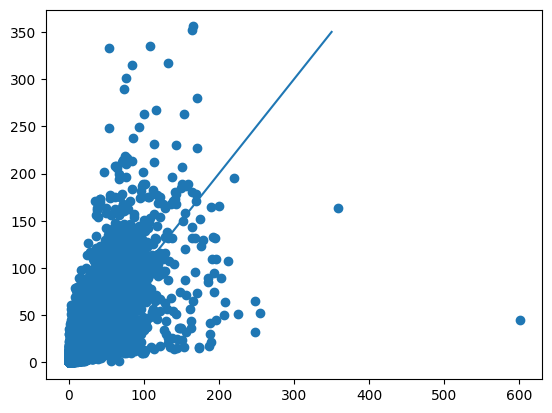

In [58]:
plt.scatter(x=df["nightlight_prev"],y=df["_mean"])
plt.plot([0,350],[0,350])
plt.show()

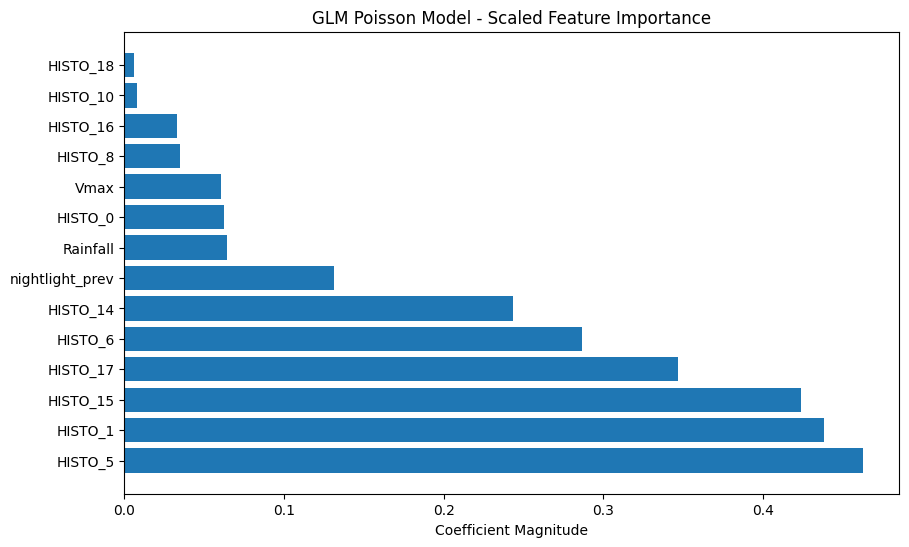

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in a pandas DataFrame called 'data'
# X should contain the features used in your model
X = df[independent_vars]
y = df[target]

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a GLM Poisson model on the scaled data
glm_model = sm.GLM(y, sm.add_constant(X_scaled), family=sm.families.Poisson()).fit()

# Get the absolute values of the coefficients
coef_abs = np.abs(glm_model.params[1:])

# Sort the coefficients in descending order
sorted_indices = np.argsort(coef_abs)[::-1]
sorted_coef_abs = coef_abs[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = X.columns[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_coef_abs)), sorted_coef_abs, align='center')
plt.yticks(range(len(sorted_coef_abs)), sorted_feature_names)
plt.xlabel('Coefficient Magnitude')
plt.title('GLM Poisson Model - Scaled Feature Importance')
plt.show()